# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report


df = pd.read_csv('tweet_sentiment_train.csv.zip')
# D:\GitHub\ML-Course\homework\Topic4\tweet_sentiment_train.csv.zip

df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [3]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
df.isna().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

# Висновки 1

- всього маємо 27481 записів, всі колонки типу об'єкт
- В даних є один пропуск по тексту, видалимо його та оновимо індекси.


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df.sentiment.value_counts(normalize=True),df.sentiment.value_counts()

(sentiment
 neutral     0.404549
 positive    0.312300
 negative    0.283151
 Name: proportion, dtype: float64,
 sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64)

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: character_count, dtype: float64

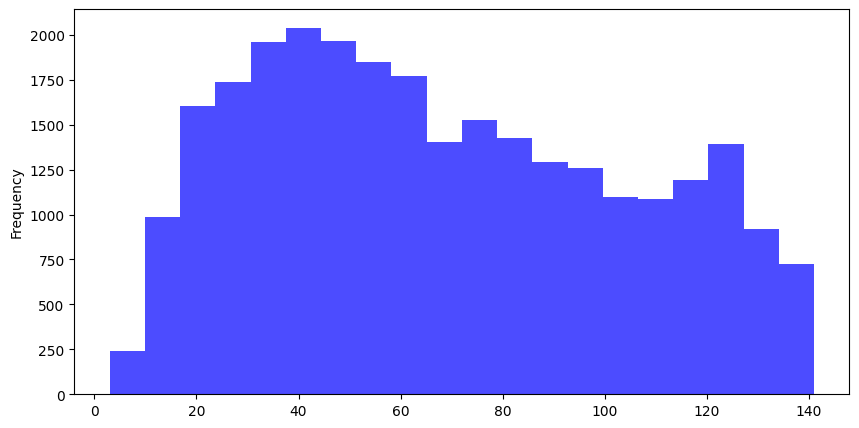

In [7]:
df_enrich = df.copy()
df_enrich['character_count'] = df_enrich['text'].apply(lambda x: len(x))
df_enrich.character_count.plot(kind='hist', bins=20, figsize=(10, 5), color='blue', alpha=0.7)
df_enrich.character_count.describe()

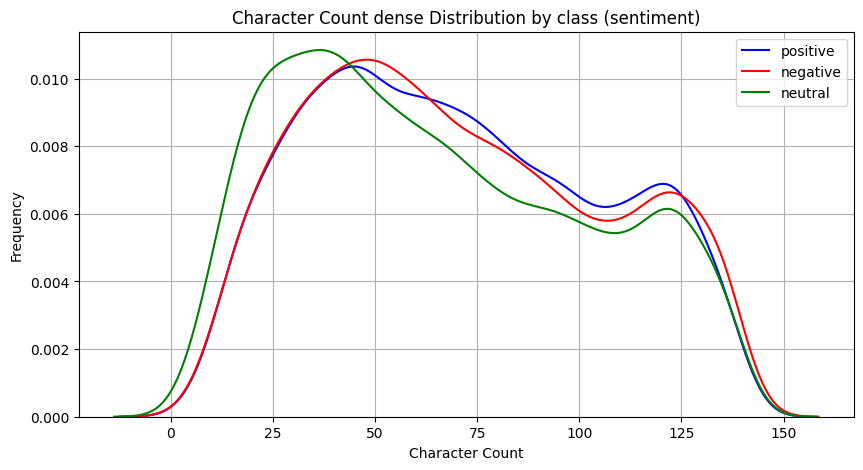

In [8]:
plt.figure(figsize=(10, 5))
plt.title('Character Count dense Distribution by class (sentiment)') 
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid()
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'positive'], label='positive', color='blue')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'negative'], label='negative', color='red')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'neutral'], label='neutral', color = 'green')
plt.legend()
plt.show()


# Висновки 2

- Спостерігається незбалансованість класів:
    - neutral  40.45%
    - positive 31.23%
    - negative 28.31%
- Довжина текстів лежить від 3 символів до 141, при тому розподіл к-ті символів по класам майже однаковий. ЕДине що нейтральний клас має здвинутий вліво пік та частіше має трохи менше символів (~35). При цьому, негативний та позитивні класи мають дуже схожі розподіли.
- При тому варто зазначити мультимодальність всіх розподілів. Спостерігається другий менш амплітудний пік в районі 125 символів


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer


In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
english_stopwords = stopwords.words('english')
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

In [12]:
stemmer = SnowballStemmer(language='english')

In [ ]:
import re
def tokenize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'http\S+|www\S+', '', text) # remove URLs
    text = re.sub(r'[^a-z\s]', '', text) # remove punctuation and special characters
    tokens = word_tokenize(text)

    tokens = remove_stopwords(tokens)
    stem = [stemmer.stem(word) for word in tokens if word not in english_stopwords] 
    return stem

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

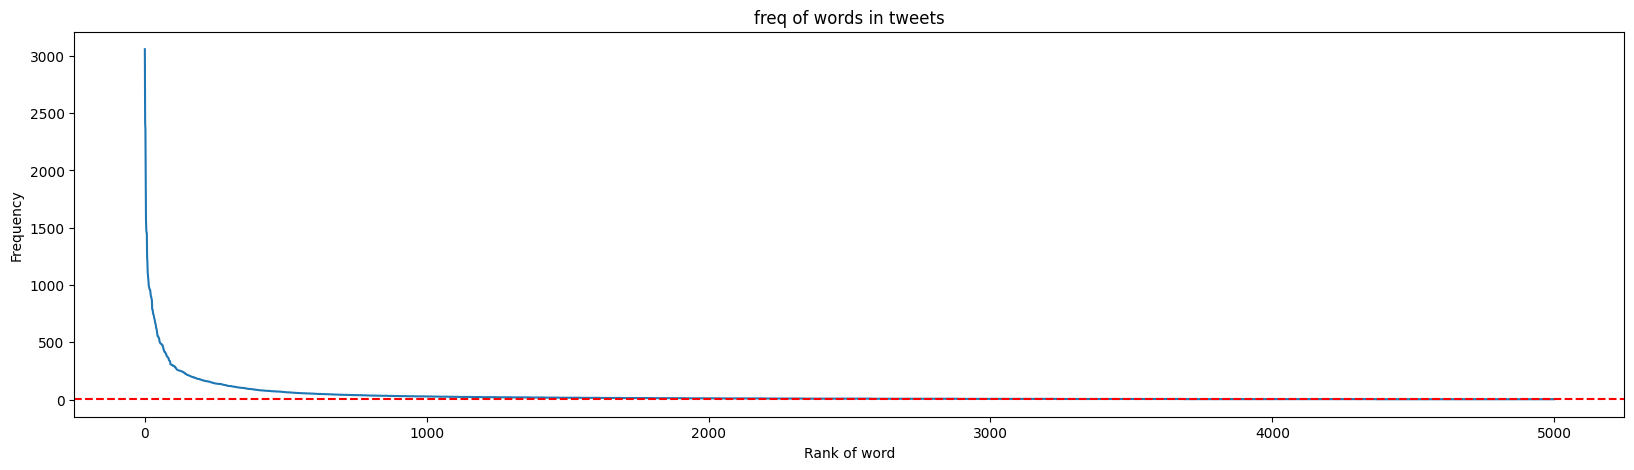

In [ ]:
from collections import Counter

all_tokens = []
for doc in df.text:  # список текстів
    all_tokens.extend(tokenize(doc))

word_freq = Counter(all_tokens)
most_common = word_freq.most_common()
frequencies = [freq for word, freq in most_common]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(frequencies[:5000])
plt.axhline(y=3, color='r', linestyle='--')

plt.xlabel("Rank of word")
plt.ylabel("Frequency")
plt.title("freq of words in tweets")
plt.show()

In [50]:
vect = CountVectorizer(tokenizer=tokenize, 
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True,
                           )
vect.fit(df.text)


CountVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x0000016346E06700>)

In [57]:
vect.get_feature_names_out()[:100], vect.get_feature_names_out()[-100:]

(array(['abl', 'absolut', 'abt', 'ac', 'accept', 'access', 'accid',
        'account', 'ace', 'ach', 'across', 'act', 'action', 'activ',
        'actual', 'ad', 'add', 'addict', 'admit', 'ador', 'advic',
        'afford', 'afraid', 'afternoon', 'age', 'ago', 'agre', 'ah', 'aha',
        'ahead', 'ahh', 'ahhh', 'ahhhh', 'aim', 'aint', 'air', 'airport',
        'alarm', 'album', 'alcohol', 'alex', 'allergi', 'allow', 'almost',
        'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'although',
        'alway', 'amaz', 'america', 'american', 'angel', 'anim', 'announc',
        'annoy', 'anoth', 'anoth one', 'answer', 'anybodi', 'anymor',
        'anyon', 'anyth', 'anytim', 'anyway', 'apart', 'app', 'appar',
        'appear', 'appl', 'appli', 'appreci', 'area', 'arent', 'argh',
        'arm', 'around', 'arriv', 'art', 'articl', 'asap', 'ashley', 'ask',
        'asleep', 'assign', 'aswel', 'ate', 'atm', 'attack', 'attempt',
        'attend', 'attent', 'august', 'australia', 'avail', 

In [17]:
inputs = vect.transform(df.text)    

# Висновки 3

- Завантажимо англійські стоп слова та створемо ф-цію remove_stopwords
- Для розбиття текст на токени створемо tokenize ф-цію яка:
    - переводить всі слова в нижній регістр
    - Видаляє спеціальні символи, посилання, хештеги (без їх видалення класифікатори працювали гірше)
    - Застосовує Стреммінг слів

- після цього ми можемо передати нашу створену ф-цію до CountVectorizer. Додатково налаштуємо параметр ngram_range=(1, 2) який дозволяє враховувати як окремі слова(уніграма), так і словосполучення пари слів (біграми) (в словнику наявні такі слова як 'work tomorrow', 'work weekend').
- Для визначення параметру довжини словника додатково проаналізуємо всі тексти аби оцінити загальну частоту зустрічання слів. По графіку видно що частота слів різко падає починаючи від 1000 та в районі 2000 доходить до 1-2 разів. Обріжемо словник на 2000 бо інші слова зустрічаються вкрай рідко (хоча вони можуть бути так само корисні)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [18]:
inputs.shape, df.shape

((27480, 2000), (27480, 4))

In [ ]:
train_index, test_index = train_test_split(df.index, test_size=0.2, stratify=df.sentiment, random_state=42)

X_train_bow = inputs[train_index]
X_test_bow = inputs[test_index]
y_train = df.sentiment[train_index]
y_test = df.sentiment[test_index]

X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape    

((21984, 2000), (5496, 2000), (21984,), (5496,))

In [20]:
labels = ['negative','neutral','positive']
encoder = LabelEncoder()
encoder.fit(labels)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [21]:
def evaluate_model(model, inputs, targets, name=''):
  y_preds = model.predict(inputs)
  # labels = model.classes_
  labels_tex = ['negative','neutral','positive']

  print(classification_report(targets, y_preds, target_names=labels))
  f1 = f1_score(targets, y_preds, average='weighted')
  print("F1 score: {:.2f}".format(f1))

  cm = confusion_matrix(targets, y_preds, normalize='true')

  plt.figure()
  ax = sns.heatmap(cm, annot=True, cmap = 'Blues',
                   xticklabels=labels_tex, yticklabels=labels_tex)
  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title('{} Confusion Matrix'.format(name))
  plt.show()

              precision    recall  f1-score   support

    negative       0.74      0.74      0.74      6225
     neutral       0.74      0.74      0.74      8894
    positive       0.80      0.81      0.80      6865

    accuracy                           0.76     21984
   macro avg       0.76      0.76      0.76     21984
weighted avg       0.76      0.76      0.76     21984

F1 score: 0.76


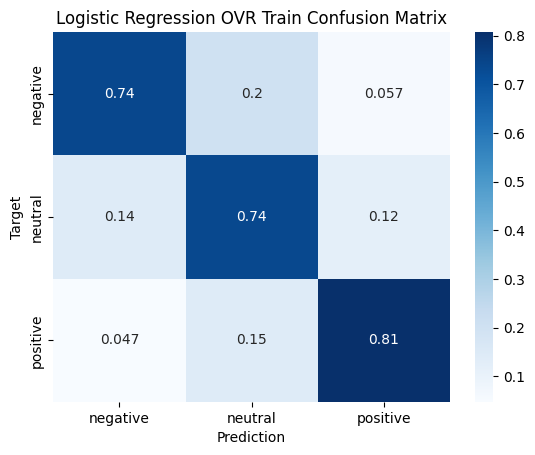

              precision    recall  f1-score   support

    negative       0.67      0.68      0.68      1556
     neutral       0.66      0.66      0.66      2223
    positive       0.75      0.74      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.69      0.69      0.69      5496
weighted avg       0.69      0.69      0.69      5496

F1 score: 0.69


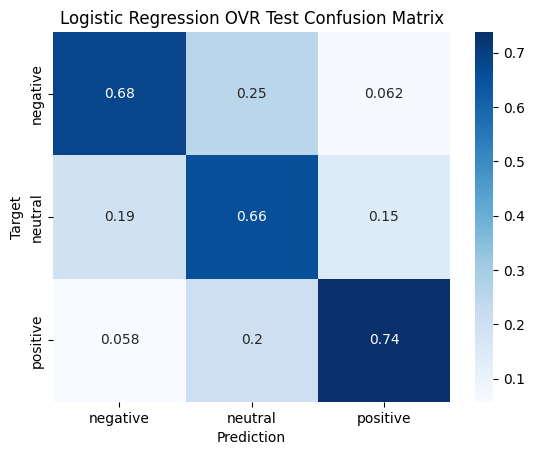

In [22]:
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000, solver='saga')
ovr_model = OneVsRestClassifier(lr)
ovr_model.fit(X_train_bow, y_train_encoded)
evaluate_model(ovr_model, X_train_bow, y_train_encoded, 'Logistic Regression OVR Train')
evaluate_model(ovr_model, X_test_bow, y_test_encoded, 'Logistic Regression OVR Test')

In [23]:
# Decision Tree Classifier

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 40, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}
dt = DecisionTreeClassifier(random_state=42)
randomSearch = RandomizedSearchCV(estimator=dt,
                           param_distributions=params,
                           n_iter=50,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=1,
                           n_jobs=-1
                          )
randomSearch.fit(X_train_bow, y_train_encoded)
best_params = randomSearch.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters found:  {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': np.int64(36), 'criterion': 'gini', 'class_weight': 'balanced'}
              precision    recall  f1-score   support

    negative       0.63      0.20      0.31      6225
     neutral       0.50      0.86      0.63      8894
    positive       0.76      0.51      0.62      6865

    accuracy                           0.57     21984
   macro avg       0.63      0.53      0.52     21984
weighted avg       0.62      0.57      0.53     21984

F1 score: 0.53


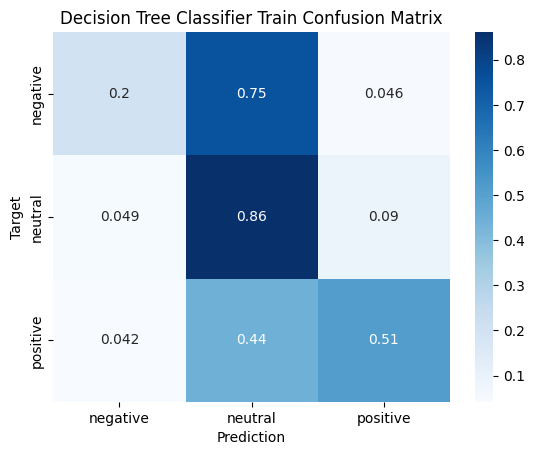

              precision    recall  f1-score   support

    negative       0.59      0.19      0.29      1556
     neutral       0.49      0.85      0.63      2223
    positive       0.77      0.52      0.62      1717

    accuracy                           0.56      5496
   macro avg       0.62      0.52      0.51      5496
weighted avg       0.61      0.56      0.53      5496

F1 score: 0.53


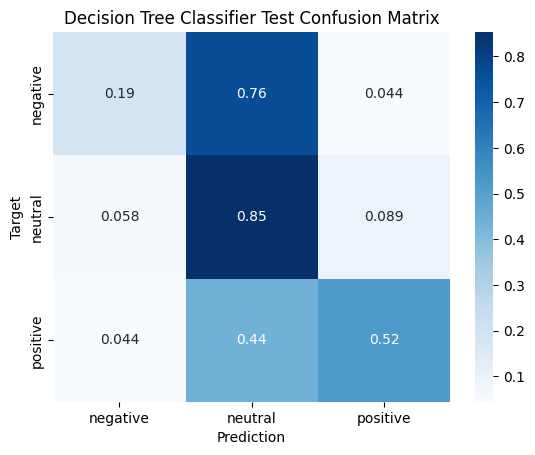

In [24]:
print("Best parameters found: ", best_params)
dt_best = randomSearch.best_estimator_
evaluate_model(dt_best, X_train_bow, y_train_encoded, 'Decision Tree Classifier Train')
evaluate_model(dt_best, X_test_bow, y_test_encoded, 'Decision Tree Classifier Test')

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:21] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.88      0.73      0.80      6225
     neutral       0.76      0.89      0.82      8894
    positive       0.88      0.83      0.85      6865

    accuracy                           0.83     21984
   macro avg       0.84      0.82      0.82     21984
weighted avg       0.83      0.83      0.83     21984

F1 score: 0.83


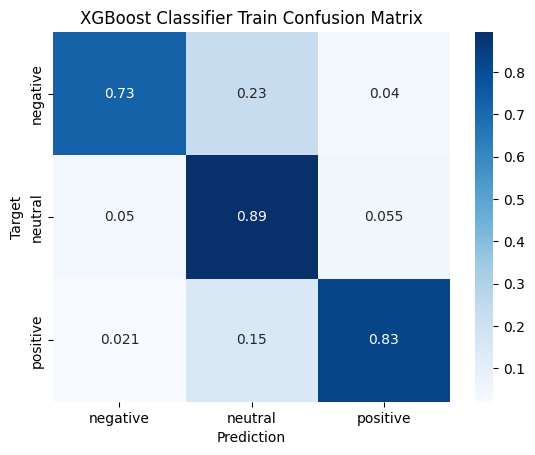

              precision    recall  f1-score   support

    negative       0.73      0.62      0.67      1556
     neutral       0.65      0.75      0.69      2223
    positive       0.77      0.72      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.72      0.70      0.70      5496
weighted avg       0.71      0.70      0.70      5496

F1 score: 0.70


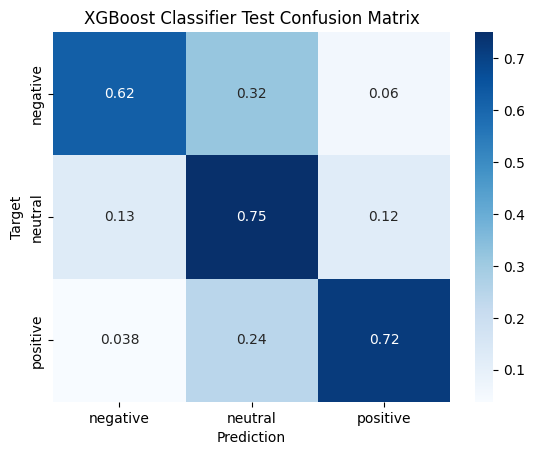

CPU times: total: 1min 15s
Wall time: 5.87 s


In [25]:
%%time
# XGBoost Classifier
# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': np.arange(2, 40, 2),
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.5, 0.7, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'class_weight': ['balanced', None]
# }

xgb = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb.fit(X_train_bow, y_train_encoded)

evaluate_model(xgb, X_train_bow, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb, X_test_bow, y_test_encoded, 'XGBoost Classifier Test')

# Висновки 4

- Збережімо розбивку індексів на тест-трейн в окремі змінні (train_index, test_index)
- Через те що маємо багатокласову класифікацію перевелемо таргет в цифри через LabelEncoder [0 == 'negative', 1 == 'neutral', 2 == 'positive']

- Для лог.регресії використаємо OneVsRestClassifier
- Для Decision Tree знайдемо найкращі параметри через RandomizedSearchCV
- Для XGBClassifier підберемо отимальні параметри вручну аби зменшити час роботи

|model|train f1|test f1|test f1 Negative| test f1 Neutral| test f1 Positive|
|-----|--------|-------|----------------|----------------|-----------------|
|Log.regress|76|69|68|66|74|
|Decision tree|53|53|29|63|62|
|XGB|83|70|67|69|74|

- На даному етапі найкращою моделлю є XGB, яка дає непогані результати. Вона має найвищу якість на тесті (F1 = 70), при тому гарний баланс між розпізнанням класів. Але можлива наявність перенавчання, бо маємо значний розрив між тренувальним та тестовим F1 (83 та 70 відповідно)
- Також найбільші плутанини виникають коли ми називаємо позитивний чи негативний клас нейтральними (що припустимо, бо інколи людям складно знайти між ними межу). Але при цьому маємо дуже малу к-ть помилок між позитивним та негативним класами, що дуже добре

- Варто зазначити що Decision tree дав найгірші результати з дуже поганою здатністю відокремлювати негативний клас


### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [26]:
feature_importances = xgb.feature_importances_
feature_names = vect.get_feature_names_out()
df_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importances = df_importances.sort_values(by='importance', ascending=False)
display(df_importances.head(20))

,feature,importance
790,happi,0.005929
1727,thank,0.005224
798,hate,0.004018
52,amaz,0.003953
875,hurt,0.003604
1475,sad,0.003314
1242,nice,0.003244
104,awesom,0.003239
566,fail,0.003139
551,excit,0.003112


# Висновки 5
Важливість ознак виглядає логічно, ми бачимо емоційно забарвленні слова які найбільше впливають на модель. По більшості слів можна логічно здогадатися на який клас вони найбільше за все впливають. При тому всі коефіціенти доволі низькі, що може означати що в нас дуже багато важливих слів і багато з них суттєво впливають на модель

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [ ]:
tfidf_vect = TfidfVectorizer(tokenizer=tokenize,
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True
                           )
tfidf_vect.fit(df.text)
inputs_tfidf = tfidf_vect.transform(df.text)
inputs_tfidf.shape, df.shape

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


((27480, 2000), (27480, 4))

In [28]:
X_train_tfidf = inputs_tfidf[train_index]
X_test_tfidf = inputs_tfidf[test_index]

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:37] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.93      0.79      0.85      6225
     neutral       0.80      0.93      0.86      8894
    positive       0.92      0.86      0.89      6865

    accuracy                           0.87     21984
   macro avg       0.89      0.86      0.87     21984
weighted avg       0.88      0.87      0.87     21984

F1 score: 0.87


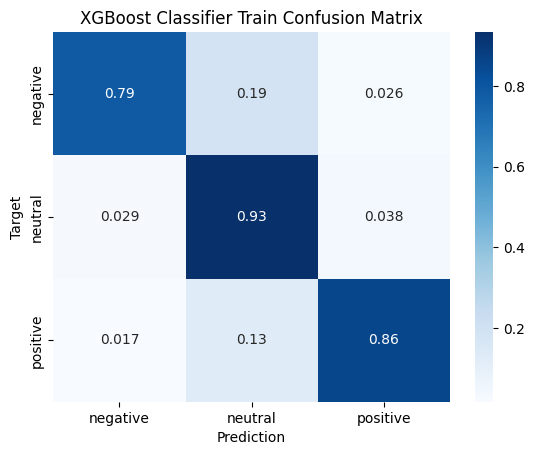

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66      1556
     neutral       0.63      0.73      0.68      2223
    positive       0.76      0.72      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496

F1 score: 0.69


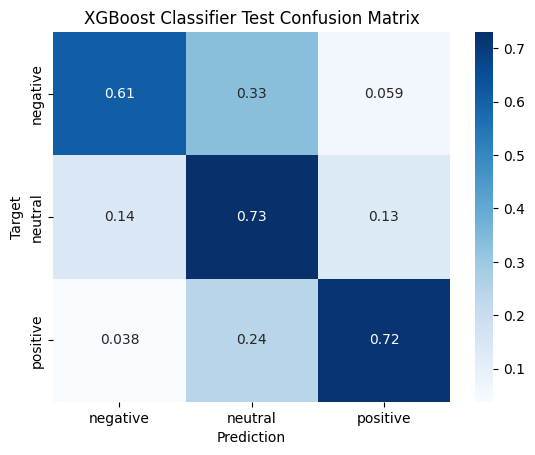

CPU times: total: 17min 26s
Wall time: 1min 21s


In [29]:
%%time
xgb_tfifd = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb_tfifd.fit(X_train_tfidf, y_train_encoded)

evaluate_model(xgb_tfifd, X_train_tfidf, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb_tfifd, X_test_tfidf, y_test_encoded, 'XGBoost Classifier Test')

In [30]:
feature_importances_tf = xgb_tfifd.feature_importances_
feature_names_tf = tfidf_vect.get_feature_names_out()
df_importances_tf = pd.DataFrame({'feature': feature_names_tf, 'importance': feature_importances_tf})
df_importances_tf = df_importances_tf.sort_values(by='importance', ascending=False)
display(df_importances_tf.head(20))

,feature,importance
790,happi,0.005394
1727,thank,0.003936
875,hurt,0.003841
798,hate,0.003376
1661,suck,0.003349
1475,sad,0.003232
52,amaz,0.003222
104,awesom,0.002873
566,fail,0.002857
1658,stupid,0.002709


In [31]:
print("XGBoost Classifier with TF-IDF features")
print((df_importances_tf.feature[:10]).tolist())
print("XGBoost Classifier with BoW features")
print((df_importances.feature[:10]).tolist()) 

XGBoost Classifier with TF-IDF features
['happi', 'thank', 'hurt', 'hate', 'suck', 'sad', 'amaz', 'awesom', 'fail', 'stupid']
XGBoost Classifier with BoW features
['happi', 'thank', 'hate', 'amaz', 'hurt', 'sad', 'nice', 'awesom', 'fail', 'excit']


In [32]:
perd_proba_tfidf = xgb_tfifd.predict_proba(X_test_tfidf)
pred_proba_bow = xgb.predict_proba(X_test_bow)
display(np.round(perd_proba_tfidf[:5], 4), np.round(pred_proba_bow[:5], 4))

array([[0.286 , 0.5775, 0.1365],
       [0.9256, 0.0658, 0.0087],
       [0.7463, 0.2259, 0.0279],
       [0.9723, 0.0233, 0.0044],
       [0.0328, 0.2332, 0.734 ]], dtype=float32)

array([[0.4125, 0.4303, 0.1572],
       [0.9246, 0.0721, 0.0034],
       [0.9901, 0.0089, 0.001 ],
       [0.8478, 0.1399, 0.0123],
       [0.0337, 0.3525, 0.6137]], dtype=float32)

In [33]:
# FOR future work 
# shap.plots.text() is strictly for models that take raw text input, not bag-of-words (BoW) or other numeric feature representations.
# -->> check alternative plots for BoW or TF-IDF representations.
#  import shap

# X_train_bow_dense = X_train_bow.toarray()
# X_test_bow_dense = X_test_bow.toarray()
# explainer = shap.Explainer(xgb, X_train_bow_dense)

# # Compute SHAP values for the test set
# shap_values = explainer(X_test_bow_dense[:100])

# shap.plots.text(shap_values[0])

In [34]:
# X_train_tfidf_dense = X_train_tfidf.toarray()
# X_test_tfidf_dense = X_test_tfidf.toarray()
# explainer_tfidf = shap.Explainer(xgb_tfifd, X_train_tfidf_dense)

# # Compute SHAP values for the test set
# shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)
# shap.plots.text(shap_values_tfidf[example_index])


# Висновки 6

- Векторизуємо слова через TfidfVectorizer використовуючі аналогічні налаштування та так само обріжемо словник до 2000 слів.
- За збереженими індексами train_index, test_index створимо нові підмасиви даних та натренуємо модель яка найкразе себе показала для BoW -> XGB.

|model|train f1|test f1|test f1 Negative| test f1 Neutral| test f1 Positive|train time|
|-----|--------|-------|----------------|----------------|-----------------|--------|
|XGB Tf-IDF|87|69|66|68|74|1min 21s|
|XGB BoW|83|70|67|69|74|5.87s|

- Схоже що ми маємо ідентичні показники на тесті. Але при цьому спостерагіється набагато більша перетренованість класифікатора для Tf-IDF (тренування = 87, тест 69). Це можна пояснити що ми використали той самий класифікатор з тими самими параметрами які в XGB ми підганяли під BoW, тому вони можуть бути неоптимальниим для нового розбиття тексті. 
- На даному етапі я б обрала **BoW розбиття тексту на вектор**, бо воно більш простіше та класифікатор натренерувавня значно швидше, що може бути важливою характеристикою при впровадженні моделі. Хоча варто зазначити що Tf-IDF має потенціал якщо покращити класифікатор, бо навіть при сильному перенавчання ми маємо таку саме тестову точністьяк і в BoW, де перенавчання трохи менше
- При аналізу топ важливих фіч, бачимо що вони дуже схожі між двома типами розбиття тексту на вектор, можна скзати що для поточного завдання вони звертають увагу на ті самі ключові слова

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [35]:
df_results = pd.DataFrame({'text': df.text[test_index], 'sentiment': y_test, 'pred_proba_tfidf': (perd_proba_tfidf).tolist(), 'pred_proba_bow': pred_proba_bow.tolist()})
df_results['pred_tfidf'] = df_results['pred_proba_tfidf'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results['pred_bow'] = df_results['pred_proba_bow'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results.head()

,text,sentiment,pred_proba_tfidf,pred_proba_bow,pred_tfidf,pred_bow
23413,Reading and taking notes but undertanding none...,negative,"[0.28595444560050964, 0.5775198936462402, 0.13...","[0.4125385880470276, 0.4302853047847748, 0.157...",neutral,neutral
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9255653619766235, 0.06577729433774948, 0.00...","[0.9245599508285522, 0.07208763808012009, 0.00...",negative,negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7462503910064697, 0.2258712500333786, 0.027...","[0.9900749325752258, 0.008876154199242592, 0.0...",negative,negative
11166,is feeling so bored... i miss school time,negative,"[0.9722999334335327, 0.02328651025891304, 0.00...","[0.8477880358695984, 0.13993678987026215, 0.01...",negative,negative
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.03277871757745743, 0.23318257927894592, 0.7...","[0.033732905983924866, 0.3525324761867523, 0.6...",positive,positive


In [ ]:
df_tfidf_results = df_results.copy()
df_tfidf_results.drop(columns=['pred_bow','pred_proba_bow'], inplace=True)
df_tfidf_results['pred_proba_tfidf'] = df_tfidf_results['pred_proba_tfidf'].apply(lambda x: np.round(x, 4))

In [60]:
# df_tfidf_results[df_tfidf_results['sentiment'] != df_tfidf_results['pred_tfidf']].head(10)

In [ ]:
# Ground truth is negative, pred is negative +
# true is negative, pred is NEUTRAL 
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9256, 0.0658, 0.0087]",negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7463, 0.2259, 0.0279]",negative
11166,is feeling so bored... i miss school time,negative,"[0.9723, 0.0233, 0.0044]",negative
22354,I am sad... Tanner wasn`t invited to the Panth...,negative,"[0.6089, 0.3818, 0.0093]",negative
26877,so hot in the office as air con been broken fo...,negative,"[0.6408, 0.2203, 0.1389]",negative
22099,For _inLaPush because she misses Quil so... F...,negative,"[0.878, 0.1114, 0.0106]",negative
3823,my teeth and head hurts,negative,"[0.9476, 0.0358, 0.0166]",negative
10246,Youtube isn`t working...and I wanted to watch ...,negative,"[0.4646, 0.3921, 0.1433]",negative
15056,aw. wasn`**** sad?! give ginger a little pat ...,negative,"[0.9705, 0.0273, 0.0023]",negative
6262,"6:29 pm - ok, let`s go now through #bowman #st...",negative,"[0.7217, 0.2521, 0.0263]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
23413,Reading and taking notes but undertanding none...,negative,"[0.286, 0.5775, 0.1365]",neutral
7935,2 hours after teleconference. but can`t go bac...,negative,"[0.4267, 0.4784, 0.0949]",neutral
17085,Im home where i am about 2 drink alone.,negative,"[0.1954, 0.6843, 0.1203]",neutral
8973,"Ah sorry to hear that, just saw pic of chi. a...",negative,"[0.2887, 0.5036, 0.2077]",neutral
27219,I can`t believe you tweeted that. It was our ...,negative,"[0.3095, 0.3685, 0.322]",neutral
20602,kate is leaving me all by my lonesome,negative,"[0.1768, 0.7203, 0.1028]",neutral
3805,ask to create a fake competetion and declare...,negative,"[0.1912, 0.7285, 0.0803]",neutral
25571,thers not many peole tweeting tonight... well ...,negative,"[0.4144, 0.4148, 0.1709]",neutral
3328,"- l`d come if u could, but Australia is just ...",negative,"[0.1622, 0.6612, 0.1766]",neutral
5965,"so, why the hell are we going to school for 2 ...",negative,"[0.3462, 0.5067, 0.1471]",neutral


In [39]:
df_tfidf_results.text.loc[23413]

'Reading and taking notes but undertanding none of it  ... HELP!'

In [ ]:
# Ground truth is positive, pred is positive +
# true is positive, pred is NEUTRAL 
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.0328, 0.2332, 0.734]",positive
24966,"Don`t worry, you`ll get your stamina back soo...",positive,"[0.0812, 0.2562, 0.6627]",positive
15657,"MIT bookstore has best book selection, but it`...",positive,"[0.0466, 0.2129, 0.7406]",positive
5449,when living in Spain..you can NEVER take a hot...,positive,"[0.0283, 0.137, 0.8347]",positive
23696,hay naku!!madaya ka talaga ah hehe ..hey happ...,positive,"[0.0009, 0.0079, 0.9911]",positive
20474,"Rachel Allens date bars, so easy to make htt...",positive,"[0.2587, 0.2875, 0.4538]",positive
2489,bahah that would be really funny she would be...,positive,"[0.0502, 0.1625, 0.7874]",positive
20938,"honestly last night was amazing, everything wa...",positive,"[0.0009, 0.0008, 0.9984]",positive
12868,Kudos! love some homemade french toast!,positive,"[0.0142, 0.1464, 0.8394]",positive
3760,8am math final wish me luck,positive,"[0.1182, 0.1088, 0.773]",positive


,text,sentiment,pred_proba_tfidf,pred_tfidf
20626,i`m just sooo in love....i think,positive,"[0.2198, 0.6218, 0.1584]",neutral
4831,yum. Do you do home delivery,positive,"[0.0907, 0.4828, 0.4265]",neutral
19359,Having a wonderful piece of cake for lunch - w...,positive,"[0.1243, 0.6169, 0.2588]",neutral
18943,_Jamie I guess ! I was really suprised..,positive,"[0.2643, 0.5686, 0.1671]",neutral
793,_KittyKat hello new follower haha!! how are ya?,positive,"[0.0437, 0.6686, 0.2878]",neutral
16610,I just KNEW you`d get that!,positive,"[0.1442, 0.7791, 0.0767]",neutral
7738,Went to get my car inspection sticker got giga...,positive,"[0.1577, 0.4722, 0.3701]",neutral
972,Heading off to Hollywood Studios today Manta ...,positive,"[0.1004, 0.5188, 0.3807]",neutral
13751,is chilling at home,positive,"[0.1518, 0.6547, 0.1935]",neutral
9076,lucky to be where i belong,positive,"[0.1685, 0.6033, 0.2282]",neutral


In [ ]:
# mosclassification positive/negative
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27111,i want so bad to go to the mcfly`s concert,positive,"[0.5746, 0.2988, 0.1266]",negative
27190,friday night is my fav night of the week but n...,positive,"[0.9017, 0.0828, 0.0155]",negative
13827,Getting some DMs asking where I fell off to th...,positive,"[0.5891, 0.3779, 0.0331]",negative
17082,aww what kind of dog do u have? I have a chih...,positive,"[0.581, 0.211, 0.208]",negative
4581,"dude, I can safely say I was blown away when ...",positive,"[0.4794, 0.1586, 0.362]",negative
17342,"$900 cheque to cash tomorrow, why I didn`t get...",positive,"[0.3736, 0.3147, 0.3117]",negative
252,almost died. Laptop screen was set to 100% bri...,positive,"[0.9063, 0.0764, 0.0173]",negative
5971,that couldn`t be more true! I like ur momma`s...,positive,"[0.5782, 0.3168, 0.105]",negative
6799,167 SQL queries to display one single deal pag...,positive,"[0.564, 0.1048, 0.3312]",negative
3226,"Bank Holiday Bliss - Jeremy Kyle, without even...",positive,"[0.5, 0.222, 0.278]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
17483,"Awww, *hugs* I wish I could help.",negative,"[0.0955, 0.1435, 0.7611]",positive
8916,_Happy_EmoX lmao. Lucky! It`s 10 minutes on fo...,negative,"[0.1706, 0.2346, 0.5948]",positive
22556,I wish I could just go for a drive..or a movie...,negative,"[0.1714, 0.1758, 0.6528]",positive
19647,"Oh, don`t spoil my fun, lol",negative,"[0.0278, 0.0682, 0.904]",positive
24468,So glad the days almost over... Another nite o...,negative,"[0.2208, 0.1198, 0.6594]",positive
21971,_Music I was not hugged,negative,"[0.0853, 0.3312, 0.5834]",positive
26766,not good enough!,negative,"[0.1593, 0.128, 0.7127]",positive
3550,Sunburnt Gutted! Hope it`s faded by tmw!,negative,"[0.1346, 0.1318, 0.7335]",positive
13854,favorite shirt ruined:death by bleach #fb,negative,"[0.1248, 0.4003, 0.4749]",positive
7525,"i wish i could offer a hug right now, so bad",negative,"[0.2733, 0.1961, 0.5306]",positive


In [42]:
df_tfidf_results.text.loc[17483]

' Awww, *hugs* I wish I could help.'

# Висновки 7

- По перше варто засередитися на випадках де негативні\позитивні тексти класифіковані як нейтральні. Бо в цих варіантам ми допускаємо найбільше помилок.
- В деяких випадках незрозуміло чому оригінально тексти були помічені як певний клас. Виглядає, що те хто робив розмітку не завжди вірно визнначали де негатиний, позитивнийчи нейтральний клас (адже частково це суб'єктивно)
- Ground true були як позитивні (хоча для мене вони звучить не як позитивні):
    - i need a hug i dnt feel so good
    - friday night is my fav night of the week but now I have to go to stupid dog training classes
    - The test today was killer. I didn`t even manage to finish on time
- Ground true були як нейтральні
    - put my dog to sleep  I love you abby RIP<3 

- Також було цікаво дослідити випадки коли класифікатор робить діаметральні помилки між позитивним та негативним класом. Наприклад, для **"not good enough!"** Ground true == негативний, але ми його розпізнали як позитивний клас (схоже що в стоп слова потрапили заперечення та їх було видаленно, хоча тут вони дуже важливі. треба ретельніше повернутися до етапу підготовки тексту)
- Також маємо помилки в складних реченнях, де декілька частин. Одна частина речення може описувати щось позитивне, а друга потім заперечити це, і класифікатор не може розпізнати яка частина більш важлива і робить неправильні висновки.
- Також в мене склалося враження що інколи під "позитивним" та "негативним" класами мають різне значення. Інколи "негативний" це про хейт та негативні висловлювання, але час від часу зустрічається що "негативним" маркували текст які мають підтримучий контент (наприклад **Awww, *hugs* I wish I could help.** звучить як підтримуючий текст і я б сказали що він позитивно забарвлений, бо людина пропонує підтримку, але в оригіналі сказано що він негативний)

Шляхи покращення класифікаціїЖ
1. Переробити лейбли класів в ручну (в ідеалі взяти думку кількох людей і вивести середнє)
2. Додати більше екземплярів де є тонка грань між класами. Там де класифікатор робить більше помилок - треба забезпечити його більш репрезентативними данимм. 
3. Зробити мільлейбл класифікацію і якщо класифікатор сумнівається чи це нейтральний клас чи емоційно задарвлений виводити два лейбла. Таком чином ми отримаємо 5 класів: позитивний, позитивно-нейтральний, нейтральний, негативно-нейтральний, негативний. Бо інколи по розподілу імовірності видно що класифікатр дуже сумніваються між двома класами (наприклад імовірності класів [0.4125, 0.4303, 0.1572])
4. Збалансувати класи. Поточний розподіл непоганий (40%, 31%, 28%), але домінація нейтральних текстів занадто виражена.


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model